<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/chronoroot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChronoRoot　（未完）
訓練済みのモデルで根の解析を行うノートブック

## ライセンス
- ChronoRoot論文, Gaggion et al., 2021, GigaScience (https://academic.oup.com/gigascience/article/10/7/giab052/6324285)
    - CC-BY
- 公式レポジトリ（https://github.com/ngaggion/ChronoRoot）
    - GPLv3
- データセット（http://gigadb.org/dataset/100911）
    - GIGAdbの利用規約が定めるライセンス（http://gigadb.org/site/term; CC0相当）に準拠
- **本章のコードは公式レポジトリのライセンスを継承してGPLv3となります。**

### メモ
python segmentFast.py imagePath --output_dir optionalSegPath --use_crf boolean --model ResUNetDS
- > 結果をchronorootで解析

GPUでcolabを実行しないとメモリエラーになる。


## 環境構築

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install onnx onnxruntime-gpu
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.6 MB/s eta 0:00:00
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-bgd7o3mx
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-bgd7o3mx
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit dd070546eda51e21ab772ee6f14807c7f5b1548b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405486 sha256=1485807a2d91347a4e623ddea36cdf0ef7ac310876a6e232ce53f2abef44b547
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [3]:
!git clone https://github.com/ngaggion/ChronoRoot

!cp /content/drive/MyDrive/phenotyping_temp_assets/Test_ChronoRoot.zip ./
!unzip Test_ChronoRoot.zip

!cp /content/drive/MyDrive/phenotyping_temp_assets/cr_resunetds.onnx ./

Cloning into 'ChronoRoot'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 108 (delta 57), reused 88 (delta 39), pack-reused 0
Receiving objects: 100% (108/108), 925.53 KiB | 3.52 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Archive:  Test_ChronoRoot.zip
   creating: Test_ChronoRoot/
   creating: Test_ChronoRoot/rpi14_2019-12-09_16-13/
   creating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-22_10-15-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-22_10-15-01_1.png  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-25_23-15-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-25_23-15-01_1.png  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-28_23-30-01_1.nii.gz  
  inflating: Test_ChronoRoot/rpi14_2019-12-09_16-13/1/2019-12-28_23-30-01_1.p

## 実行コード

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import onnxruntime as ort

import pydensecrf.densecrf as dcrf

In [7]:
def crf_process(prediction):
    accum = np.zeros(prediction.shape[1:3])
    image = cv2.cvtColor((prediction[0,:,:,0]*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(prediction[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)

    accum = 0.8 * accum + crf_map[:,:,1]
    _, outimg = cv2.threshold(accum, 0.5, 1.0, cv2.THRESH_BINARY)
    return outimg


def pad_image_to_multiple_of_32(img_path):
    # Read the grayscale image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Calculate the required padding for height and width
    pad_height = 32 - (img.shape[0] % 32) if img.shape[0] % 32 != 0 else 0
    pad_width = 32 - (img.shape[1] % 32) if img.shape[1] % 32 != 0 else 0

    # Pad the image
    padded_img = cv2.copyMakeBorder(img,
                                    0, pad_height,  # top, bottom padding
                                    0, pad_width,   # left, right padding
                                    cv2.BORDER_CONSTANT,
                                    value=0)  # 0 is for black in grayscale

    return padded_img

def pad_image_to_multiple_of(v, multipleOf=[8, 8], mode='symmetric'):
    padding = ((0, 0 if v.shape[0] % multipleOf[0] == 0 else multipleOf[0] - (v.shape[0] % multipleOf[0])),
               (0, 0 if v.shape[1] % multipleOf[1] == 0 else multipleOf[1] - (v.shape[1] % multipleOf[1])))
    return np.pad(v, padding, mode)

def preprocess(image):
    # assure dtype is float32
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    return image


5
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)


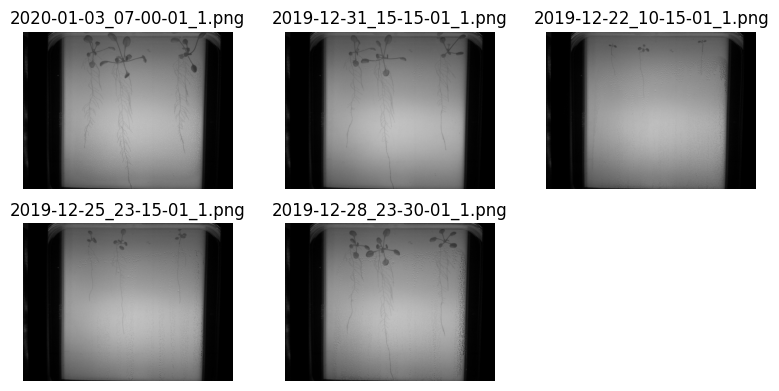

In [9]:
TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = [x for x in os.listdir(TEST_DIR) if x.endswith(".png")]
print(len(files))  # 5枚

plt.figure(figsize=(8,4))
for i, file in enumerate(files):
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path)
    print(image.shape)
    image = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    plt.subplot(2,3,i+1)
    plt.title(file)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()

In [9]:
# 気孔開閉判定モデルの読み込み
classifier_path = "/content/cr_resunetds.onnx"
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['x:0']
Output names: ['pixel_wise_softmax/truediv:0']


In [6]:
!mkdir result

In [10]:
TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = sorted([x for x in os.listdir(TEST_DIR) if x.endswith(".png")])

for i, file in enumerate(files):
    print(file)
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path, 0 )
    image = preprocess(image)
    # print(image.shape)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    prediction = ort_session.run(output_names, {"x:0": image})[0]
    # print(prediction.shape)
    out = crf_process(prediction)
    cv2.imwrite(os.path.join("result",file), out)

    # plt.figure(figsize=(20,8))
    # plt.subplot(1,3,1)
    # plt.title("raw output channel 0")
    # plt.imshow(prediction[0,...,0], cmap="gray")

    # plt.subplot(1,3,2)
    # plt.title("accum")
    # plt.imshow(accum, cmap="gray")

    # plt.subplot(1,3,3)
    # plt.title("final output")
    # plt.imshow(outimg, cmap="gray")
    # plt.show()

2019-12-22_10-15-01_1.png
2019-12-25_23-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-31_15-15-01_1.png
2020-01-03_07-00-01_1.png


### indivisual plant analysis

In [17]:
Load the experiment data on config.conf:


# ========== Paths ==========

## The path where the video-sequence is.
Path = "/media/ngaggion/Datasets/rpi6/1"

## The path where the output segmentation was saved.
## For example, using the ensemble of models:
SegPath = os.path.join(Path, 'SegEnsemble')

## The path where we will be saving each plant analysis.
Project = "/media/ngaggion/Experiment1"

# ========== Analysis ==========

# Setting up the end of the experiment
# Set to a number to limitate the maximum number of frames.
# 0 = OFF, ChronoRoot will run until no images are left
# For example 1344 (4 frames * 24 hours * 14 days)

Limit = 1344

# ========== RSML METADATA ==========

fileKey = "Long day condition" # Identifier for the RSML file
sequenceLabel = "rpi6" # Identifier for the sequence
Plant = "Arabidopsis thaliana" # Plant under study

python chronoRoot.py